<a href="https://colab.research.google.com/github/SeanSDarcy2001/CISProgrammingAssignments/blob/main/CIS1HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Integrated Surgery: Programming Assignment 1

Alexandra Szewc

aszewc1

Seby Darcy

sdarcy2

# Import Modules

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares

## PART 1
Develop (or develop proficiency with) a Cartesian math package for 3D points, rotations, and frame transformations.

In [2]:
## use package to represent 3D points
p1    = np.array([-1489., -4913.,  4345.])
p2    = np.array([ 2633., -3268.,  5249.])
pcalc = np.array([-3210., -4390.,  3930.])

def norm(v):
    return v / np.sqrt(np.dot(v, v))

In [3]:
## use packages to represent 3D rotations
def identity():
  return np.array([[1, 0,  0], [0, 1, 0], [0, 0, 1]])

# generate skew matrix from 1x3 array 
def skew(v) :
  skewArg = norm(v)
  ax = skewArg[0]
  ay = skewArg[1]
  az = skewArg[2]
  skew = np.array([[0,    -az,  ay],
                   [az,   0,    -ax],
                   [-ay,  ax,   0]])
  return skew

# generate 3D Rotation matrix
# @Params: alpha, beta, gamma - Rotation angles about the x, y, and z axes respectively
# @Returns: 3D Rotation matrix
def RotfromAngles(alpha, beta, gamma) :
  Rx = np.array([[1, 0,  0], [0, np.cos(alpha), -np.sin(alpha)], [0, np.sin(alpha), np.cos(alpha)]])
  Ry = np.array([[np.cos(beta), 0,  np.sin(beta)], [0, 1, 0], [-np.sin(beta), 0, np.cos(beta)]])
  Rz = np.array([[np.cos(gamma), -np.sin(gamma),  0], [np.sin(gamma), np.cos(gamma), 0], [0, 0, 1]])
  R = RotfromComponents(Rx, Ry, Rz)
  return R

def smallAngleR(v, theta) :
  n = norm(v)
  return (identity() + skew(theta * n))

def RotfromComponents(Rx, Ry, Rz) :
  R = np.dot(np.dot(Rx, Ry), Rz)
  return R

# convert 3D vector into 4D homogeneous coords
def homogenousVector(v, scale) :
  Vx = scale * v[0]
  Vy = scale * v[1]
  Vz = scale * v[2]
  return np.array([Vx, Vy, Vz, scale])

In [4]:
## use packages to represent 3D frame transformations

class Frame:
  
  def __init__(self, R, p):
    self.R = R
    self.p = p
    self.F = self.getFrame()

  # define Frame using Rotation and Translation
  # @Params: Rotation R and Translation p
  # @Return: Frame
  def getFrame(self):
    F = np.row_stack((np.column_stack((self.R, self.p)),
                      [0,0,0,1]))
    return F

  # applies frame transformation to vector
  # @Params: Frame F and Vector v
  # @Return: transformed vector
  def appFrame(self, v):
    return np.dot(self.F, v)

  # applies inverse frame transformation to vector
  # @Params: Frame F and Vector v
  # @Return: transformed vector
  def appInvFrame(self, v):
    Finv = Frame(self.R.T, - (np.dot(self.R.T, self.p)))
    return np.dot(Finv.getFrame(), v)

# Test Module

Test module to verify performance of Frame data structure.

In [5]:
# Rotation test
R = RotfromAngles(0, 1, 0)
print(R)

# Transform test
p = np.array([5, 7, 9])
F = Frame(R, p)
print(F.getFrame())

one_t = np.array([[0,0,0],[1,0,0],[0,1,0]])
two_t = np.array([[0,0,1], [1,0,1],[0,0,2]])

# Transformation is 90 degree rot over x and +1 translation on z
# Tested here
R = RotfromAngles(90, 0, 0)
p = (0,0,1)
F = Frame(R, p)
n = homogenousVector(one_t[0],1)
print((n))
print(F.appFrame(n))

[[ 0.54030231  0.          0.84147098]
 [ 0.          1.          0.        ]
 [-0.84147098  0.          0.54030231]]
[[ 0.54030231  0.          0.84147098  5.        ]
 [ 0.          1.          0.          7.        ]
 [-0.84147098  0.          0.54030231  9.        ]
 [ 0.          0.          0.          1.        ]]
[0 0 0 1]
[0. 0. 1. 1.]


## PART 2

Develop a 3D point set to 3D point set registration algorithm

In [6]:
# Function to compute transformation between two point
# clouds of known correspondance using SVD (for fun).
# @Params:  a - first point cloud
#           b - second point cloud
# @Returns: Frame(R, p) - a Frame transform from a to b
#
# K. Arun, et. al., IEEE PAMI, Vol 9, no 5, pp 698-700, Sept 1987 
def rigid_registration_Arun(a, b):
    a = a.T
    b = b.T

    # Calculate and subtract means
    a_c = np.expand_dims(np.mean(a, axis = 1), axis=1)
    b_c = np.expand_dims(np.mean(b, axis = 1), axis=1)
    A = a - a_c
    B = b - b_c

    # Compute SVD
    H = np.dot(A, B.T)
    U, X, V_t = np.linalg.svd(H)
    R = np.dot(V_t.T, U.T)
    if (np.allclose(np.linalg.det(R), 1)):
        p = b_c - np.matmul(R, a_c)
        return Frame(R, p)
    elif (np.allclose(np.linalg.det(R), -1)):
        assert 0 in H
        V = V_t.T
        V[:,2] = np.negative(V[:,2])
        R = np.dot(V, U.T)
        p = b_c - np.matmul(R, a_c)
    return Frame(R, p)

In [7]:
# Function to compute transformation between two point
# clouds of known correspondance. 3D registration.
# @Params:  a - first point cloud
#           b - second point cloud
# @Returns: Frame(R, p) - a Frame transform from a to b
def rigid_registration(a, b):
    a = a.T
    b = b.T

    # Calculate and subtract means
    a_c = np.expand_dims(np.mean(a, axis = 1), axis=1)
    b_c = np.expand_dims(np.mean(b, axis = 1), axis=1)
    A = a - a_c
    B = b - b_c

    # Compute H
    H = np.dot(A, B.T)
    delta = np.array([[H[1][2] - H[2][1],
                       H[2][0] - H[0][2],
                       H[0][1] - H[1][0]]]).T

    G = np.row_stack((
        np.column_stack(( np.trace(H), delta.T )),
        np.column_stack(( delta, (H + H.T - np.trace(H)*np.eye(3)) ))
                      ))
    l, Q = np.linalg.eig(G)
    qi = np.argmax(l)

    # Quarternion for rotation
    q = Q[:,qi]
    R = np.array([[q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2,
                   2*(q[1]*q[2] - q[0]*q[3]),
                   2*(q[1]*q[3] + q[0]*q[2])],
                  
                  [2*(q[1]*q[2] + q[0]*q[3]),
                   q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2,
                   2*(q[2]*q[3] - q[0]*q[1])],

                  [2*(q[1]*q[3] - q[0]*q[2]),
                   2*(q[2]*q[3] + q[0]*q[1]),
                   q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2]])
    
    p = b_c - np.matmul(R, a_c)
    return Frame(R, p)

# Test Module

Test module for 3D-registration.

In [8]:
# TEST MODULE FOR 3D REGISTRATION
# Two sets of points to check 3D-3D registration
one_t = np.array([[0,0,0],[1,0,0],[0,1,0]])
two_t = np.array([[0,0,1], [1,0,1],[0,0,2]])

reg = rigid_registration(one_t, two_t)
res = np.dot(reg.R, one_t.T) + reg.p
if np.allclose(res, two_t.T):
    print("Success!")
else:
    print("Registration failed.")

Success!


## PART 3

Develop a “pivot” calibration method

Yaniv 2015 <https://dx.doi.org/10.1117/12.2081348>

In [9]:
# Function to perform sphere-fitting pivot calibration.
# @Params:  frames - the N X 4 X 4 ndarray of frames to perform calibration
# @Returns: list of the following:
#           ptr_o  - 3-Dimensional pointer offset 1 X 3 ndarray
#           ptr_p  - coordinates of the pivot point 1 X 3 ndarray
#           err    - RMS error about centroid of pivot
def pivotCalibration(frames) :
    err = -1.0
    trans = frames[:, 0:3, 3]

    # Find pivot point in world coordinates using sphere fitting
    pivot = np.concatenate([np.mean(trans, axis=0), np.zeros(1)])

    # Compute least squares optimization for unknown point
    x_s = trans[:, 0]
    y_s = trans[:, 1]
    z_s = trans[:, 2]
    res = least_squares(func, pivot,
                        bounds=((-np.inf, -np.inf, -np.inf, -np.inf),
                                (np.inf, np.inf, np.inf, np.inf)),
                        jac='3-point',
                        args=(x_s, y_s, z_s))

    ptr_p = res.x[0:3]

    # Calculate mean offset
    offsets = np.zeros((frames.shape[0], 3))

    rot = frames[:, 0:3, 0:3]
    for i, rot in enumerate(rot):
        offsets[i] = rot.transpose() @ (ptr_p - trans[i])
    ptr_o = np.mean(offsets, axis=0)

    # Calculate residual error (root mean square error)
    x_v = np.concatenate([ptr_o, ptr_p],axis=0).reshape((6, 1))
    num = frames.shape[0]

    # Concatenate rotation and -I for each frame
    a_0 = (frames[:, 0:3, 0:3]).reshape((3*num,3))
    a_1 = (np.eye(3) * -1.0).reshape((1, 3, 3)).repeat(num, 0).reshape((3*num,3))
    a_v = np.concatenate((a_0, a_1), axis=1)

    # -1 * translation for each frame
    b_v = (frames[:, 0:3, 3] * -1.0).reshape(((3*num,1)))

    # Compute residuals
    resid = (np.dot(a_v, x_v) - b_v)
    err = np.sqrt(np.mean(resid * resid))

    return [ptr_o, ptr_p, err]

# Function to calculate distance of given
# points from center and radius given
# by the pivot.
def func(pvt, x_s, y_s, z_s):
    # Calculate distance from given center
    dist = np.sqrt((x_s - pvt[0])**2 +
                      (y_s - pvt[1])**2 +
                      (z_s - pvt[2])**2)

    return dist - pvt[3]

# File I/O Methods

In [10]:
# Function to read the data file for registration point locations.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           d_coords - coordinates of d N_D X 3 ndarray
#           a_coords - coordinates of a N_A X 3 ndarray
#           c_coords - coordinates of c N_C X 3 ndarray
def read_calbody(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-calbody.txt"
    dat = pd.read_csv(path)

    N_D, N_A, N_C, FILE = dat.columns
    N_D = int(N_D)
    N_A = int(N_A) + N_D
    N_C = int(N_C) + N_A

    dat = dat.to_numpy()
    d_coords = dat[0:N_D,   0:3]
    a_coords = dat[N_D:N_A, 0:3]
    c_coords = dat[N_A:N_C, 0:3]

    # Outputs marker types x marker points x coords
    return [d_coords, a_coords, c_coords]

# Function to read the data file for caibration readings.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           D_coords - coordinates of D F X N_D X 3 ndarray
#           A_coords - coordinates of A F X N_A X 3 ndarray
#           C_coords - coordinates of C F X N_C X 3 ndarray
def read_calreadings(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-calreadings.txt"
    dat = pd.read_csv(path)

    N_D, N_A, N_C, N_F, FILE = dat.columns
    N_D = int(N_D)
    N_A = int(N_A) + N_D
    N_C = int(N_C) + N_A
    N_F = int(float(N_F))

    dat = dat.to_numpy()
    D_coords = np.array([dat[0:N_D,   0:3]])
    A_coords = np.array([dat[N_D:N_A, 0:3]])
    C_coords = np.array([dat[N_A:N_C, 0:3]])
    for n in range(1, N_F):
        D_coords = np.append(D_coords,
                  np.array([dat[((n*N_C)):((n*N_C) + N_D),       0:3]]),
                  axis=0)
        A_coords = np.append(A_coords,
                  np.array([dat[((n*N_C) + N_D):((n*N_C) + N_A), 0:3]]),
                  axis=0)
        C_coords = np.append(C_coords,
                  np.array([dat[((n*N_C) + N_A):((n*N_C) + N_C), 0:3]]),
                  axis=0)

    # Outputs marker types x frames x marker points x coords
    return [D_coords, A_coords, C_coords]

# Function to read the data file for the EM probe.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           G_coords - coordinates of G F X N X 3 ndarray
def read_empivot(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-empivot.txt"
    dat = pd.read_csv(path)

    N_G, N_F, FILE = dat.columns
    N_G = int(N_G)
    N_F = int(float(N_F))

    dat = dat.to_numpy()
    G_coords = np.array([dat[0:N_G,   0:3]])
    for n in range(1, N_F):
        G_coords = np.append(G_coords,
                  np.array([dat[((n*N_G)):((n*N_G) + N_G),       0:3]]),
                  axis=0)

    # Outputs marker types x frames x marker points x coords
    return [G_coords]

# Function to read the data file for the optical probe.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           D_coords - coordinates of D F X N X 3 ndarray
#           H_coords - coordinates of H F X N X 3 ndarray
def read_optpivot(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-optpivot.txt"
    dat = pd.read_csv(path)

    N_D, N_H, N_F, FILE = dat.columns
    N_D = int(N_D)
    N_H = int(N_H) + N_D
    N_F = int(float(N_F))

    dat = dat.to_numpy()
    D_coords = np.array([dat[0:N_D,   0:3]])
    H_coords = np.array([dat[N_D:N_H, 0:3]])
    for n in range(1, N_F):
        D_coords = np.append(D_coords,
                  np.array([dat[((n*N_H)):((n*N_H) + N_D),       0:3]]),
                  axis=0)
        H_coords = np.append(H_coords,
                  np.array([dat[((n*N_H) + N_D):((n*N_H) + N_H), 0:3]]),
                  axis=0)

    # Outputs list of marker types x frames x marker points x coords
    return [D_coords, H_coords]

# Function to read output of debug data set.
# @Params:  name   - name of data set being used
# @Returns: list of the following:
#           em_pt  - coordinates of the EM probe 1 X 3 ndarray
#           opt_pt - coordinates of the optical probe 1 X 3 ndarray
#           c_exp - coordinates of the expected values of C F X N X 3 ndarray
def read_output(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-output1.txt"
    dat = pd.read_csv(path)

    N_C, N_F, FILE = dat.columns
    N_C = int(N_C)
    N_F = int(float(N_F))

    dat = dat.to_numpy()
    em_probe = np.array(dat[0, 0:3])
    opt_probe = np.array(dat[1, 0:3])
    C_coords = np.array([dat[2:2+N_C, 0:3]])
    for n in range(1, N_F):
        C_coords = np.append(C_coords,
                             np.array([dat[((2+n*N_C)):((2+n*N_C) + N_C), 0:3]]),
                             axis=0)

    # Outputs list of em_probe, opt_probe, frames x marker points x coords
    return [em_probe, opt_probe, C_coords]

# Function to write all output data to a text file.
# @Params: name   - name of the file
#          em_pt  - coordinates of the EM probe 1 X 3 ndarray
#          opt_pt - coordinates of the optical probe 1 X 3 ndarray
#          c_exp - coordinates of the expected values of C F X N X 3 ndarray
def write_output(name, em_pt, opt_pt, C_exp):
    path = name + '-output1.txt'
    with open(path, 'w') as f:
        f.write('{}, {}, {}\n'.format(C_exp.shape[1], C_exp.shape[0], path))
        cw = csv.writer(f, delimiter=',')
        cw.writerow(em_pt)
        cw.writerow(opt_pt)
        for frame in range(C_exp.shape[0]):
            for marker in range(C_exp.shape[1]):
                cw.writerow(C_exp[frame][marker])
    files.download(path)

## Part 4

Given a distortion calibration data set, as described above, compute the “expected” values $\overrightarrow{C_i}^{(expected)}$ for the $\overrightarrow{C_i}$:

a. For each calibration data frame $[\overrightarrow{D_1}, ..., \overrightarrow{D_{N_D}}, \overrightarrow{A_1}, ..., \overrightarrow{A_{N_A}}, \overrightarrow{C_1}, ..., \overrightarrow{C_{N_C}}]$, compute the transformation between optical tracker $F_D$ and EM tracker coordinates. I.e., compute a frame $F_D$ such that $\overrightarrow{D_j} = F_D \cdot \overrightarrow{d_j}$.

b. Similarly, compute a transformation $F_A$ between calibration object and optical tracker coordinates. I.e., $\overrightarrow{A_j} = F_A \cdot \overrightarrow{a_j}$.

c. Given $F_D$ and $F_A$, compute $\overrightarrow{C_i}^{(expected)} = F_D^{-1} \cdot F_A \cdot \overrightarrow{c_j}$.

d. Output $\overrightarrow{C_i}^{(expected)}$ (see file formats below)

In [11]:
# Function to compute the expected values of C.
# @Params: name   - name of data set being used
#          save   - whether or not the output file is to be saved
#          em_pt  - coordinates of the EM probe
#          opt_pt - coordinates of the optical probe
# @Returns: c_exp - coordinates of the expected values of C
def give_C_exp(name, save=False,
               em_pt=np.array([0,0,0]),
               opt_pt=np.array([0,0,0])):
    # Prepare arrays
    calibration_data_frames = read_calreadings(name)
    D = calibration_data_frames[0]
    A = calibration_data_frames[1]
    C = calibration_data_frames[2]
    nf = D.shape[0]

    tracker_coordinates = read_calbody(name)
    em_tracker = tracker_coordinates[0]
    opt_tracker = tracker_coordinates[1]
    c_vec = tracker_coordinates[2]

    C_exp = np.zeros((nf, c_vec.shape[0], 3))
    for f in range(nf):

        # Compute the transformation between optical
        # tracker F_D and EM tracker coordinates
        F_D = rigid_registration(em_tracker, D[f])

        # Compute the transformation between calibration
        # object F_D and optical tracker coordinates
        F_A = rigid_registration(opt_tracker, A[f])

        # # Compute C_exp
        C_exp_temp = np.zeros((1,4))
        for nc in range(c_vec.shape[0]):
            c_j = np.array([F_D.appInvFrame(F_A.appFrame(homogenousVector(c_vec[nc,:],1)))])
            C_exp_temp = np.append(C_exp_temp, c_j, axis=0)
        C_exp[f] = C_exp_temp[1:,0:3]
    if (save):
        write_output(name, em_pt, opt_pt, C_exp)
    return C_exp

## Part 5

Apply the EM tracking data to perform a pivot calibration for the EM probe and determine the position relative to the EM tracker base coordinate system of the dimple in the calibration post. The suggested procedure is as follows.

a. Use the first “frame” of pivot calibration data to define a local “probe” coordinate system and use this to compute $\overrightarrow{g_j}$. One simple method is as follows. First compute the midpoint of the observed points
$$
\overrightarrow{G_0} = \frac{1}{N_G} \sum \overrightarrow{G_j}
$$
Then translate the observations relative to this midpoint. I.e., compute
$$
\overrightarrow{g_j} = \overrightarrow{G_j} - \overrightarrow{G_0}
$$
There are alternative methods, many of which involve rotating $\overrightarrow{g_j}$. But this isn’t particularly critical. Your pivot calibration will determine a tip coordinates $\overrightarrow{t_G}$ defined in the same probe coordinate system. I.e., if $F_G(t)$ gives the position and orientation of the pointer body at time $t$ with respect to some tracker coordinate system, then $F_G(t) \cdot \overrightarrow{t_G}$ gives the coordinates of the pointer tip with respect to the same tracker coordinate system.

b. For each “frame” of pivot data, compute a transformation such that $\overrightarrow{G_j} = F_G[k] \cdot \overrightarrow{g_j}$.

c. Now use the method discussed in class to solve the system
$$
\overrightarrow{P}_{dimple} = F_G[k] \cdot \overrightarrow{t_G}
$$

In [12]:
# Function to apply EM tracking data to perform a pivot calibration
# of the EM tracking probe.
# @Params: name    - name of data set being used
# @Returns: em_pts - coordinates of EM probe wr/ EM tracker
def em_pivot_calibration(name):
    em_data = read_empivot(name)
    G = em_data[0]
    nf = G.shape[0]
    ng = G.shape[1]

    # Use the first "frame" of pivot calibration data to define
    # a local "probe" coordinate system.
    first_frame = G[0]
    G_0 = np.zeros((1, 3))
    for j in range(ng):
        G_0 += first_frame[j]
    G_0 /= ng

    # Now compute g_j
    g = np.zeros((ng, 3))
    for j in range(ng):
        g[j] = first_frame[j] - G_0

    # Compute F_G transforms using rigid registration
    F_G = np.zeros((1, 4, 4))
    for k in range(nf):
        F_G = np.append(F_G,
                        np.array([rigid_registration(g, G[k]).getFrame()]),
                        axis=0)
    em_pt = (pivotCalibration(F_G[1:,:,:]))[1]
    return em_pt

## Part 6

Apply the optical tracking data to perform a pivot calibration of the optical tracking probe. The suggested method is the same as above except that you should first use your value for $F_D$ to transform the optical tracker beacon positions into EM tracker coordinates. Note that the optical tracker may not be in exactly the same position and orientation with respect to the EM tracker base for each observation frame of optical tracker data, so this is an important step.

In [13]:
# Function to apply optical tracking data to perform a pivot calibration
# of the optical tracking probe.
# @Params: name     - name of data set being used
# @Returns: opt_pts - coordinates of optical probe wr/ optical tracker
def opt_pivot_calibration(name):
    opt_data = read_optpivot(name)
    tracker_coordinates = read_calbody(name)
    em_tracker = tracker_coordinates[0]
    
    D = opt_data[0]
    H = opt_data[1]
    nf = D.shape[0]
    nd = D.shape[1]
    nh = H.shape[1]

    # Use F_D value to transform H's into EM coordinates
    for k in range(nf):
        F_D = rigid_registration(em_tracker, D[k])
        for j in range(nh):
            H[k][j] = (F_D.appInvFrame(homogenousVector(H[k][j], 1))[:3])

    # Use the first "frame" of pivot calibration data to define
    # a local "probe" coordinate system.
    first_frame = H[0]

    H_0 = np.zeros((1, 3))
    for j in range(nh):
        H_0 += first_frame[j]
    H_0 /= nh

    # Now compute h_j
    h = np.zeros((nh, 3))
    for j in range(nh):
        h[j] = first_frame[j] - H_0

    # Compute F_H transforms using rigid registration
    F_H = np.zeros((1, 4, 4))
    for k in range(nf):
        F_H = np.append(F_H,
                        np.array([rigid_registration(h, H[k]).getFrame()]),
                        axis=0)

    opt_pt = (pivotCalibration(F_H[1:,:,:]))[1]
    return opt_pt

# Output Test

Performs comparison between output files and computed output.

In [14]:
# Function to test similarity between given
# output file, computed output values. Outputs
# correctness based on error parameter.
# @Params: true - list of em and opt coordinates and C_exp values
#                 for all frames and markers from given output
#          comp - list of em and opt coordinates and C_exp values
#                 for all frames and markers from computed output
#          err  - maximum difference between any coordinate for an
#                 output to be considered correct
def test_similarity(true, comp, err):
    # Given coordinates
    em_pt_t = true[0]
    opt_pt_t = true[1]
    c_exp_t = true[2]

    # Computed coordinates
    em_pt_c = comp[0]
    opt_pt_c = comp[1]
    c_exp_c = comp[2]

    # Checking EM probe
    print('Estimated post position with\
    EM probe pivot calibration: ')
    if (np.all(np.fabs(em_pt_t - em_pt_c) < err)):
        print('Correct!\n')
    else:
        print('Out of bounds\n')

    # Checking optical probe
    print('Estimated post position with\
    optical probe pivot calibration: ')
    if (np.all(np.fabs(opt_pt_t - opt_pt_c) < err)):
        print('Correct!\n')
    else:
        print('Out of bounds\n')

    # Checking C_exp values
    sum_crr = 0
    sum_err = 0
    tot = c_exp_t.shape[0] * c_exp_t.shape[1]
    for f in range(c_exp_t.shape[0]):
        for n in range(c_exp_t.shape[1]):
            if (np.all(np.fabs(c_exp_t[f][n] - c_exp_c[f][n]) < err)):
              sum_crr += 1
            else:
              sum_err += 1

    print('{:.2f}% of C_exp correct'.format(100 * sum_crr / tot))

# Main Module

Run to perform tests on debug data and export predictions for unknown data.

In [15]:
debug_sets = ['pa1-debug-a', 'pa1-debug-b', 'pa1-debug-c', 'pa1-debug-d',
              'pa1-debug-e', 'pa1-debug-f', 'pa1-debug-g']

unknown_sets = ['pa1-unknown-h', 'pa1-unknown-i', 'pa1-unknown-j']

# Run comparisons for debug sets
for d in debug_sets:
    print(d + '\n')
    em = em_pivot_calibration(d)
    op = opt_pivot_calibration(d)
    c = give_C_exp(d, False, em_pt=em, opt_pt=op)
    out = read_output(d)
    test_similarity(out, [em, op, c], 3.25)
    print('--------------------------------------------------------')

# Export output for unknown sets
for d in unknown_sets:
    em = em_pivot_calibration(d)
    op = opt_pivot_calibration(d)
    c = give_C_exp(d, True, em_pt=em, opt_pt=op)

pa1-debug-a

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa1-debug-b

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa1-debug-c

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa1-debug-d

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa1-debug-e

Estimated post posi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RESULTS and ANALYSIS


pa1-debug-a 0.25
pa1-debug-b 0.75
pa1-debug-c 1
pa1-debug-d 0.25
pa1-debug-e 3.25
pa1-debug-f 3.25
pa1-debug-g 2.75


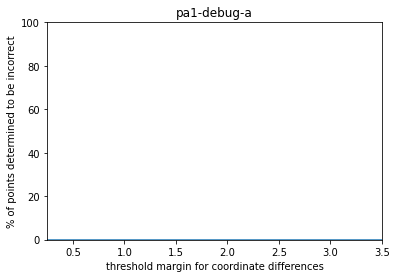

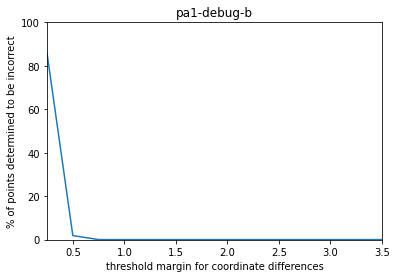

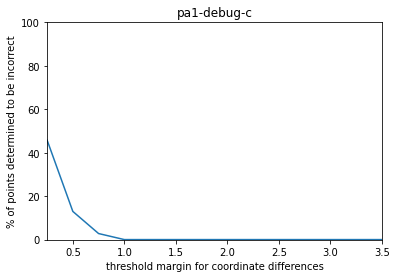

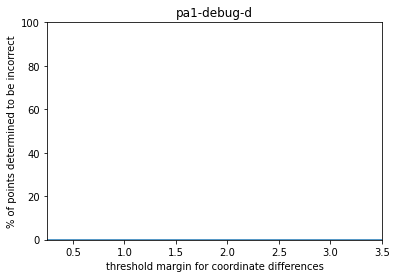

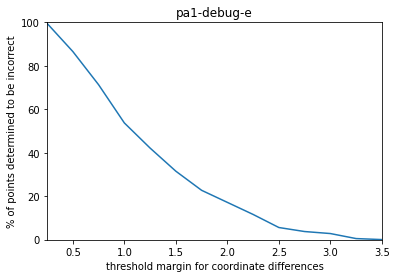

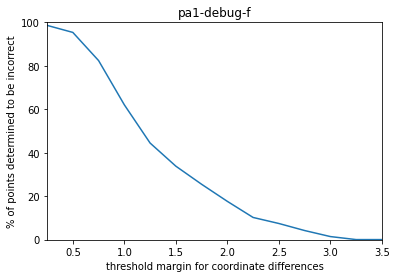

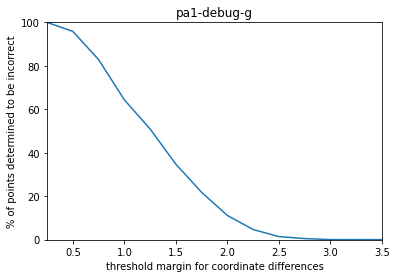

In [16]:
# Function to test similarity between given
# output file, computed output values. Outputs
# correctness based on error parameter.
# @Params: true - list of em and opt coordinates and C_exp values
#                 for all frames and markers from given output
#          comp - list of em and opt coordinates and C_exp values
#                 for all frames and markers from computed output
#          err  - maximum difference between any coordinate for an
#                 output to be considered correct
# @Returns: acc - % of calculated C_exp points determined to be accurate
def test_similarity2(true, comp, err):
    # Given coordinates
    em_pt_t = true[0]
    opt_pt_t = true[1]
    c_exp_t = true[2]

    # Computed coordinates
    em_pt_c = comp[0]
    opt_pt_c = comp[1]
    c_exp_c = comp[2]

    # Checking C_exp values
    sum_crr = 0
    sum_err = 0
    tot = c_exp_t.shape[0] * c_exp_t.shape[1]
    for f in range(c_exp_t.shape[0]):
        for n in range(c_exp_t.shape[1]):
            if (np.all(np.fabs(c_exp_t[f][n] - c_exp_c[f][n]) < err)):
              sum_crr += 1
            else:
              sum_err += 1
    acc = (100 * sum_crr / tot)
    return acc


# Function to generate % error vs coordinate threshold value plots
# for each debugging set.
# @Params: debug - list of debug sets
def resultsTables(debug) :
  thresholds = [.25, .5, .75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5]

  for d in range(len(debug)):
    inaccuracy = []
    acceptableThres = -1
    found = False
    for thres in thresholds :
        em = em_pivot_calibration(debug[d])
        op = opt_pivot_calibration(debug[d])
        c = give_C_exp(debug[d], False, em_pt=em, opt_pt=op)
        out = read_output(debug[d])
        inaccurate = 100 - test_similarity2(out, [em, op, c], thres)
        if (inaccurate < .5 and found == False) :
          acceptableThres = thres
          found = True
        inaccuracy.append(inaccurate)
    plt.figure()
    plt.title(debug[d])
    plt.xlabel("threshold margin for coordinate differences")
    plt.ylabel("% of points determined to be incorrect")
    plt.ylim(-.1, 100)
    plt.xlim(.25, 3.5)
    plt.plot(thresholds, inaccuracy)
    print(debug[d], acceptableThres)

resultsTables(debug_sets)

# Contributions

## Seby


*   developed proficiency with a Cartesian math package for 3D points rotations, and frame transformations. (1)
*   documented functionality and variable significance
* developed results methods, analysis and figures


## Alex


*   developed proficiency with a Cartesian math package for 3D points rotations, and frame transformations. (1)
*   created Frame object with transformation functionality. (1)
*   developed algorithm for 3D-3D registration. (2)
*   developed method for pivot calibration using sphere fitting. (3)
*   developed method for problem 4 (description above). (4)
*   developed method for problem 5 (description above). (5)
*   developed method for problem 6 (description above). (6)
*   developed methods for reading in files for application. (4-6)
*   created unit tests for all output files. (4-6)
*   commenting functions/modules. (all)



# Computer Integrated Surgery: Programming Assignment 2

In this assignment, you will fit polynomials to model distortion and then use these polynomials to “dewarp” the EM tracker space. You will use the dewarped EM tracker space to repeat your pivot calibration. Then you will use the resulting calibration to compute registration to a CT coordinate system. Finally, given some pointer data frames, you will report corresponding CT coordinates.

## Part 1

Input the body calibration data file and process it to determine the values of $\overrightarrow{C}_i^{(expected)}[k]$ corresponding to each $\overrightarrow{C}_i[k]$ in each “frame” $k$ of data.

In [17]:
# Running code from PA1
debug_sets = ['pa2-debug-a', 'pa2-debug-b', 'pa2-debug-c',
              'pa2-debug-d', 'pa2-debug-e', 'pa2-debug-f']

unknown_sets = ['pa2-unknown-g', 'pa2-unknown-h',
                'pa2-unknown-i', 'pa2-unknown-j']

# Run comparisons for debug sets
for d in debug_sets:
    print(d + '\n')
    em = em_pivot_calibration(d)
    op = opt_pivot_calibration(d)
    c = give_C_exp(d, False, em_pt=em, opt_pt=op)
    out = read_output(d)
    test_similarity(out, [em, op, c], 2)
    print('--------------------------------------------------------')

pa2-debug-a

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa2-debug-b

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa2-debug-c

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

99.94% of C_exp correct
--------------------------------------------------------
pa2-debug-d

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
--------------------------------------------------------
pa2-debug-e

Estimated post posit

# File I/O Methods for PA2

In [18]:
# Function to read the file describing CT fiducial coordinates b.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           b_coords - coordinates of fiducials (b) N X 3 ndarray
def read_ctfiducials(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-ct-fiducials.txt"
    dat = pd.read_csv(path)

    N_B, FILE = dat.columns
    N_B = int(N_B)

    dat.reset_index(level=0, inplace=True)
    dat = dat.to_numpy()
    b_coords = dat[0:N_B,   0:3]

    # Outputs list of fiducial landmarks x coords
    return [b_coords]
        
# Function to read the file that describes frames of data in which the probe
# is in contact with the corresponding CT fiducials.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           G_coords - coordinates of G F X N_G X 3 ndarray
def read_emfiducials(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-em-fiducialss.txt"
    dat = pd.read_csv(path)

    N_G, N_B, FILE = dat.columns
    N_G = int(N_G)
    N_B = int(float(N_B))

    dat = dat.to_numpy()
    G_coords = np.array([dat[0:N_G,   0:3]])
    for n in range(1, N_B):
        G_coords = np.append(G_coords,
                  np.array([dat[((n*N_G)):((n*N_G) + N_G),       0:3]]),
                  axis=0)

    # Outputs frames x EM marker points x coords
    return [G_coords]
        
# Function to read the file that describes frames of data
# defining test points.
# @Params:  name     - name of data set being used
# @Returns: list of the following:
#           G_coords - coordinates of G F X N_G X 3 ndarray
def read_emnav(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-EM-nav.txt"
    dat = pd.read_csv(path)

    N_G, N_F, FILE = dat.columns
    N_G = int(N_G)
    N_F = int(float(N_F))

    dat = dat.to_numpy()
    G_coords = np.array([dat[0:N_G,   0:3]])
    for n in range(1, N_F):
        G_coords = np.append(G_coords,
                  np.array([dat[((n*N_G)):((n*N_G) + N_G),       0:3]]),
                  axis=0)

    # Outputs frames x EM marker points x coords
    return [G_coords]

# Function ro read file that gives positions of probe tip
# in CT coordinates, corresponding to the frames of data
# in NAME-EM-NAV.TXT.
# @Params:  name      - name of data set being used
# @Returns: list of the following:
#           v_coords  - coordinates of the probe tip in CT coordinates the
#                   for each frame: F X 3 ndarray
def read_output2(name):
    path = "https://raw.githubusercontent.com/SeanSDarcy2001/CISProgrammingAssignments/main/data/" + name + "-output2.txt"
    dat = pd.read_csv(path)

    N_F, FILE = dat.columns
    N_F = int(N_F)

    dat.reset_index(level=0, inplace=True)
    dat = dat.to_numpy()
    v_coords = dat[0:N_F,   0:3]

    # Outputs list of frames x coords
    return [v_coords]

# Function to write all output2 data to a text file.
# @Params: name        - name of the file
#           v_coords  - coordinates of the probe tip in CT coordinates the
#                   for each frame: F X 3 ndarray
def write_output2(name, v_coords):
    path = name + '-output2.txt'
    with open(path, 'w') as f:
        f.write('{}, {}\n'.format(v_coords.shape[0], path))
        cw = csv.writer(f, delimiter=',')
        for frame in range(v_coords.shape[0]):
            cw.writerow(v_coords[frame])
    files.download(path)

## Part 2

Use the method described in class to produce a suitable distortion correction function.

In [19]:
import scipy.special as sp
import scipy

# Function to scale values in q to a bounding box
# @Params: q - an ndarray of dimensions n x 3
# @Return: u - a scaled ndarray of dimensions n x 3
# def ScaleToBox(q):
#     q_min = np.min(q, axis=0)
#     q_max = np.max(q, axis=0)

#     u = (q - q_min) / (q_max - q_min)

#     return u
def ScaleToBox(q, q_min, q_max):
    u = np.zeros(q.shape)
    for i in range(q.shape[0]):
        for c in range(3):
            u[i,c] = (q[i,c] - q_min[c]) / (q_max[c] - q_min[c])

    return u

# Testing of ScaleToBox function
# r = read_ctfiducials('pa2-debug-a')
# print(r)
# print(ScaleToBox(r))

# Function to compute the fifth degree Bernstein
# polynomial.
# @Params: v   - argument for computation
# @Return: sum - 5th order polynomial
def B(v, k, N=5):
    return (sp.binom(N, k) * ((1-v)**(N-k)) * ((v)**k))

# @Param: u - scaled values returned by sensor
def compute_distortion(p, q, q_min, q_max, N=5):
    # Scale sensor values 
    u = ScaleToBox(q, q_min, q_max)

    # Define dimensions of F array
    S = p.shape[0]
    N = (N+1)**3

    F = np.zeros((S, N))
    # Setting up least squares problem
    for s in range(S):
        u_x = u[s, 0]
        u_y = u[s, 1]
        u_z = u[s, 2]

        ind = 0
        for i in range(5+1):
            for j in range(5+1):
                for k in range(5+1):
                    F[s][ind] = B(u_x,i) * B(u_y,j) * B(u_z,k)
                    ind += 1

    # Perform least squares
    c = scipy.linalg.lstsq(F,p)[0]
    # c = np.linalg.inv(F.T @ F) @ F.T @ p

    # Return c's
    return c

def correct_distortion(x, name, N=5):
    # Load in c_exp ground truth and distorted c
    c_exp = give_C_exp(name)
    p = c_exp.reshape(c_exp.shape[0] * c_exp.shape[1], 3)

    C = read_calreadings(name)[2]
    q = C.reshape(C.shape[0] * C.shape[1], 3)

    # Compute scaling box bounds
    q_min = np.min(q, axis=0)
    q_max = np.max(q, axis=0)

    # Compute distortion correction
    c = compute_distortion(p, q, q_min, q_max)

    # Scale sensor values
    u = ScaleToBox(x, q_min, q_max)

    # Apply correction to find "ground truth"
    r = np.zeros((u.shape[0], 3))
    for s in range(u.shape[0]):
        sum = 0
        u_x = u[s, 0]
        u_y = u[s, 1]
        u_z = u[s, 2]

        for i in range(N+1):
            for j in range(N+1):
                for k in range(N+1):
                    sum += B(u_x,i) * B(u_y,j) * B(u_z,k) * c[i*36 + j*6 + k]

        r[s] = sum

    return r

## Part 3

Use this distortion correction function to repeat your “pivot calibration” for the EM probe.

In [20]:
def em_pivot_calib_raw(G, nf, ng, ptip=True):
    # Use the first "frame" of pivot calibration data to define
    # a local "probe" coordinate system.
    first_frame = G[0]
    G_0 = np.zeros((1, 3))
    for j in range(ng):
        G_0 += first_frame[j]
    G_0 /= ng

    # Now compute g_j
    g = np.zeros((ng, 3))
    for j in range(ng):
        g[j] = first_frame[j] - G_0

    # Compute F_G transforms using rigid registration
    F_G = np.zeros((1, 4, 4))
    for k in range(nf):
        F_G = np.append(F_G,
                        np.array([rigid_registration(g, G[k]).getFrame()]),
                        axis=0)
        
    if (ptip):
        em_pt = (pivotCalibration(F_G[1:,:,:]))[0] # p_tip
    else:
        em_pt = (pivotCalibration(F_G[1:,:,:]))[1] # p_dimple for debugging
        print('DEBUG: dimple given')

    return em_pt

# Function to apply EM tracking data to perform a "pivot calibration"
# of the EM tracking probe following distortion correction.
# @Params: name    - name of data set being used
# @Returns: em_pts - coordinates of EM probe wr/ EM tracker
def em_pivot_calibration_distortion_correction(name, ptip=True):
    em_data = read_empivot(name)
    G = em_data[0]
    nf = G.shape[0]
    ng = G.shape[1]

    # Dewarp EM tracker space
    G_ = G.reshape(nf * ng, 3)
    G = correct_distortion(G_, name).reshape(nf, ng, 3)

    return em_pivot_calib_raw(G, nf, ng, ptip=ptip)

In [21]:
d = 'pa2-debug-c'

x = em_pivot_calibration(d)
y = em_pivot_calibration_distortion_correction(d, ptip=False)
z = read_output(d)[0]

print(x)
print(y)
print(z)

c = give_C_exp(d, False, em_pt=em, opt_pt=op)
out = read_output(d)
test_similarity(out, [em, op, c], .5)

DEBUG: dimple given
[206.86036797 199.3041258  207.98028754]
[207.36857147 199.32992755 207.69715773]
[207.38 199.33 207.69]
Estimated post position with    EM probe pivot calibration: 
Out of bounds

Estimated post position with    optical probe pivot calibration: 
Out of bounds

77.93% of C_exp correct


## Part 4

Using the distortion correction and the improved pivot value, compute the locations of the $\overrightarrow{b}_j$ fiducials points with respect to the EM tracker base coordinate system.

In [22]:
def locate_fiducials_em(name):
    # Obtain fiducial locations in CT coordinates
    b = read_ctfiducials(name)[0]
    nf = b.shape[0] # number of fiducials

    # Obtain G locations for fiducials and dewarp
    bEM = read_emfiducials(name)[0]
    ng = bEM.shape[1] # number of points per fidicual

    # Dewarp
    bEM = bEM.reshape(nf * ng, 3)
    bEM = correct_distortion(bEM, name).reshape(nf, ng, 3)

    # Obtain pivot value
    p_tip = em_pivot_calibration_distortion_correction(name)

    B = np.zeros(b.shape)
    for i in range(nf):
        # Current fiducial
        b_coords = b[i]
        G = bEM[i]
        ng = G.shape[0]
        
        # Use the first "frame" of pivot calibration data to define
        # a local "probe" coordinate system.
        first_frame = read_empivot(name)[0][0] #G
        G_0 = np.zeros((1, 3))
        for j in range(ng):
            G_0 += first_frame[j]
        G_0 /= ng

        # Now compute g_j
        g = np.zeros((ng, 3))
        for j in range(ng):
            g[j] = first_frame[j] - G_0

        # Compute F_G transforms using rigid registration
        # per b_j
        F_ptr = rigid_registration(g, G)
        B[i] = (F_ptr.appFrame(homogenousVector(p_tip, 1))[:3])

    return [B]

## Part 5

Compute the registration frame $F_{reg}$.

In [23]:
def comp_F_reg(name):
    F_reg = rigid_registration(locate_fiducials_em(name)[0], read_ctfiducials(name)[0])

    # print("CT FIDS")
    # print(read_ctfiducials(name)[0])

    # print("EM FIDS")
    # for f in locate_fiducials_em(name)[0]:
    #     # print(f)
    #     print(F_reg.appFrame(homogenousVector(f, 1))[:3])
    return F_reg

In [28]:
d = 'pa2-debug-a'

em = em_pivot_calibration(d)
op = opt_pivot_calibration(d)
c = give_C_exp(d, False, em_pt=em, opt_pt=op)
v = nav_to_CT_coords(d)
out = read_output2(d)

print("V")
print(v)

print("OUT")
print(out[0])

test2_similarity2(out, [v], 10)

V
[[148.3251629  118.97468448  43.20017373]
 [ 76.25879367 116.05687305 152.64152261]
 [ 36.90150769 148.37030436 170.97627661]
 [ 75.8047078   75.61426728 172.00382188]]
OUT
[[148.33 118.97  43.2 ]
 [ 76.26 116.06 152.64]
 [ 36.9  148.38 170.97]
 [ 75.8   75.62 172.  ]]
100.00% of v_i correct


## Part 6

Apply the distortion correction to all the subsequent values of $[\overrightarrow{G}_1, ..., \overrightarrow{G}_{N_G}]$, compute the pointer tip coordinates with respect to the tracker base, and apply $F_{reg}$ to compute the tip location with respect to the CT image.

In [25]:
def nav_to_CT_coords(name):
    # Fetch F_reg
    F_reg = comp_F_reg(name)

    # Read in em nav test points
    Gt = read_emnav(name)[0]
    nf = Gt.shape[0]
    ng = Gt.shape[1]

    # Dewarp point values
    Gt_ = Gt.reshape(nf * ng, 3)
    Gt = correct_distortion(Gt_, name).reshape(nf, ng, 3)

    # Fetch p_tip
    p_tip = em_pivot_calibration_distortion_correction(name)

    # Compute the pointer tip coordinates
    # with respect to the tracker base
    tips = np.zeros((nf, 3))
    for i in range(nf):
        G = Gt[i]
        
        # Use the first "frame" of pivot calibration data to define
        # a local "probe" coordinate system.
        first_frame = read_empivot(name)[0][0] #G
        G_0 = np.zeros((1, 3))
        for j in range(ng):
            G_0 += first_frame[j]
        G_0 /= ng

        # Now compute g_j
        g = np.zeros((ng, 3))
        for j in range(ng):
            g[j] = first_frame[j] - G_0

        # Compute F_reg transforms using rigid registration
        # per navigation test point
        F_ptr = rigid_registration(g, G)
        tip = F_ptr.appFrame(homogenousVector(p_tip, 1))
        tips[i] = (F_reg.appFrame(tip)[:3])
    
    return tips

# Output Test

Performs comparison between output files and computed output.

In [27]:
# Function to test similarity between given
# output2 file, computed output values. Outputs
# correctness based on error parameter.
# @Params: true - list of v_i values
#                 for all frames and markers from given output
#          comp - list of v_i values
#                 for all frames and markers from computed output
#          err  - maximum difference between any coordinate for an
#                 output to be considered correct
def test2_similarity2(true, comp, err):
    # Given coordinates
    v_t = true[0]

    # Computed coordinates
    v_c = comp[0]

    # Checking C_exp values
    sum_crr = 0
    sum_err = 0
    tot = v_t.shape[0] * v_t.shape[1]
    for f in range(v_t.shape[0]):
        for n in range(v_t.shape[1]):
            if (np.all(np.fabs(v_t[f][n] - v_c[f][n]) < err)):
              sum_crr += 1
            else:
              sum_err += 1

    print('{:.2f}% of v_i correct'.format(100 * sum_crr / tot))

# Main Module

Run to perform tests on debug data and export predictions for unknown data.

In [29]:
# Redefine PA2 sets
debug_sets = ['pa2-debug-a', 'pa2-debug-b', 'pa2-debug-c',
              'pa2-debug-d', 'pa2-debug-e', 'pa2-debug-f']

unknown_sets = ['pa2-unknown-g', 'pa2-unknown-h',
                'pa2-unknown-i', 'pa2-unknown-j']

# Run comparisons for debug sets
for d in debug_sets:
    print(d + '\n')
    em = em_pivot_calibration(d)
    op = opt_pivot_calibration(d)
    c = give_C_exp(d, False, em_pt=em, opt_pt=op)
    out = read_output(d)
    test_similarity(out, [em, op, c], 2)

    v = nav_to_CT_coords(d)
    
    print("V")
    print(v)
    
    write_output2(d, v)
    out = read_output2(d)

    print("OUT")
    print(out)

    test2_similarity2(out, [v], 10)
    print('--------------------------------------------------------')

# Export output for unknown sets
for d in unknown_sets:
    em = em_pivot_calibration(d)
    op = opt_pivot_calibration(d)
    c = give_C_exp(d, True, em_pt=em, opt_pt=op)
    v = nav_to_CT_coords(d)
    write_output2(d, v)

pa2-debug-a

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
V
[[148.3251629  118.97468448  43.20017373]
 [ 76.25879367 116.05687305 152.64152261]
 [ 36.90150769 148.37030436 170.97627661]
 [ 75.8047078   75.61426728 172.00382188]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUT
[array([[148.33, 118.97,  43.2 ],
       [ 76.26, 116.06, 152.64],
       [ 36.9 , 148.38, 170.97],
       [ 75.8 ,  75.62, 172.  ]])]
100.00% of v_i correct
--------------------------------------------------------
pa2-debug-b

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
V
[[ 89.23951653  84.14857762 170.90886063]
 [ 39.55327946 163.42834961 157.59793117]
 [117.79383132 156.1854034   81.80364237]
 [ 35.08691053  36.12390359 134.62533449]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUT
[array([[ 89.36,  84.06, 170.89],
       [ 39.49, 163.5 , 157.59],
       [117.8 , 156.28,  81.82],
       [ 35.05,  36.12, 134.66]])]
100.00% of v_i correct
--------------------------------------------------------
pa2-debug-c

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

99.94% of C_exp correct
V
[[ 91.76356915  88.67008456 161.37417127]
 [ 46.40212984 130.75443748  99.1566983 ]
 [127.89031044  95.65388004 172.43168571]
 [107.2242621   64.20545177  39.33333655]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUT
[array([[ 91.58,  88.22, 161.13],
       [ 45.84, 130.7 ,  99.31],
       [127.69,  96.27, 171.75],
       [106.51,  64.04,  39.39]])]
100.00% of v_i correct
--------------------------------------------------------
pa2-debug-d

Estimated post position with    EM probe pivot calibration: 
Correct!

Estimated post position with    optical probe pivot calibration: 
Correct!

100.00% of C_exp correct
V
[[125.32518485 148.45258965  50.20073723]
 [105.36688665  79.75401103  97.6995074 ]
 [162.47871538  32.46658496  47.74599179]
 [ 47.11641888 138.05589373  27.11862211]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUT
[array([[125.32, 148.45,  50.2 ],
       [105.36,  79.75,  97.7 ],
       [162.48,  32.46,  47.75],
       [ 47.11, 138.06,  27.11]])]
100.00% of v_i correct
--------------------------------------------------------
pa2-debug-e

Estimated post position with    EM probe pivot calibration: 
Out of bounds

Estimated post position with    optical probe pivot calibration: 
Correct!

88.44% of C_exp correct
V
[[157.43608368  67.46462696 119.85655655]
 [ 88.49121091  79.25645919  79.59474194]
 [ 31.45390314 169.723626    96.91536408]
 [ 72.39255598  36.56807898  70.11965818]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUT
[array([[162.54,  75.83, 117.41],
       [ 85.95,  79.76,  84.7 ],
       [ 46.12, 169.36,  99.29],
       [ 66.75,  45.67,  74.91]])]
91.67% of v_i correct
--------------------------------------------------------
pa2-debug-f

Estimated post position with    EM probe pivot calibration: 
Out of bounds

Estimated post position with    optical probe pivot calibration: 
Correct!

76.74% of C_exp correct
V
[[115.23089869  31.30096907 137.91077547]
 [ 42.06777847 170.8106765   55.51399122]
 [ 38.95336803  62.62688012  59.59946697]
 [ 65.9460657  132.02145978  90.23447058]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUT
[array([[116.28,  32.7 , 139.46],
       [ 41.21, 171.9 ,  54.37],
       [ 40.91,  60.94,  58.9 ],
       [ 65.44, 133.55,  90.05]])]
100.00% of v_i correct
--------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Contributions

## Seby


*  Researched algorithm methods for each part. (all)


## Alex


*   Wrote File I/O for PA2. (all)
*   Developed distortion correction function and dependencies. (2)
*   Developed modified pivot calibration of EM probe. (3)
*   Wrote code to compute location of fiducial landmarks with respect to EM tracker system. (4)
*   Function to compute $F_{reg}$. (5)
*   Applied $F_{reg}$ to other values to conver to CT coordinates. (6)
*   Created test suite for PA2. (all)
